# SHPB Analysis Pipeline with RDF Integration

This notebook demonstrates the complete workflow for analyzing Split Hopkinson Pressure Bar (SHPB) experimental data with full ontology integration.

## Workflow Overview

1. **Specimen Selection** - Query specimens from the ontology database
2. **Raw Data Loading** - Load and validate CSV signal data
3. **Equipment Configuration** - Extract bar and gauge properties from ontology
4. **Pulse Detection** - Detect incident, transmitted, and reflected pulse windows
5. **Pulse Segmentation** - Center and normalize detected pulses
6. **Pulse Alignment** - Optimize temporal alignment for equilibrium
7. **Stress-Strain Calculation** - Compute engineering and true stress-strain curves
8. **Equilibrium Assessment** - Calculate validity metrics (FBC, DSUF, SEQI, SOI)
9. **ML Preprocessing** - Apply Tukey window tapering for neural network input
10. **RDF Export** - Save test metadata and results to ontology

## Requirements

- Specimen must exist in `user_data/specimens/` (created via GUI)
- Raw CSV file with time, incident, and transmitted voltage columns
- Equipment definitions in ontology (`mechanical_testing_individuals.ttl`)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from pathlib import Path
from datetime import datetime

# Add project root to path
proj_root = Path.cwd().parent.parent
sys.path.insert(0, str(proj_root))

# SHPB Analysis Toolkit
from dynamat.mechanical.shpb import (
    PulseDetector, 
    PulseAligner, 
    StressStrainCalculator, 
    TukeyWindow
)

# SHPB Data IO
from dynamat.mechanical.shpb.io import (
    SpecimenLoader,
    SHPBTestWriter,
    SHPBTestMetadata,
    CSVDataHandler
)

# Ontology Management
from dynamat.ontology import OntologyManager
from dynamat.ontology.qudt.qudt_manager import QUDTManager

print("All imports loaded successfully")

All imports loaded successfully


---
## 1. Specimen Selection

Query the ontology to find available specimens. Specimens must be created via the GUI before running this analysis.

In [3]:
# Initialize ontology managers
ontology_manager = OntologyManager()
qudt_manager = QUDTManager()
specimen_loader = SpecimenLoader(ontology_manager)

# Load all specimen files from user_data/specimens/
files_loaded = specimen_loader.load_specimen_files()
print(f"Specimen files loaded: {files_loaded}")

# ============================================================
# USER INPUT: Specify material to filter specimens
# ============================================================
MATERIAL_FILTER = "dyn:SS316_A356"  # Change to your material URI

specimens = specimen_loader.find_specimens(material_name=MATERIAL_FILTER)

if specimens:
    print(f"\nAvailable {MATERIAL_FILTER} specimens:")
    for idx, specimen in enumerate(specimens):
        print(f"  [{idx:3d}] {specimen['id']}")
    print(f"\nTotal: {len(specimens)} specimens")
else:
    print(f"No specimens found for material: {MATERIAL_FILTER}")

Specimen files loaded: 209

Available dyn:SS316_A356 specimens:
  [  0] DYNML-SS316A356-0001
  [  1] DYNML-SS316A356-0002
  [  2] DYNML-SS316A356-0003
  [  3] DYNML-SS316A356-0004
  [  4] DYNML-SS316A356-0005
  [  5] DYNML-SS316A356-0006
  [  6] DYNML-SS316A356-0007
  [  7] DYNML-SS316A356-0008
  [  8] DYNML-SS316A356-0009
  [  9] DYNML-SS316A356-0010
  [ 10] DYNML-SS316A356-0011
  [ 11] DYNML-SS316A356-0012
  [ 12] DYNML-SS316A356-0013
  [ 13] DYNML-SS316A356-0014
  [ 14] DYNML-SS316A356-0015
  [ 15] DYNML-SS316A356-0016
  [ 16] DYNML-SS316A356-0017
  [ 17] DYNML-SS316A356-0018
  [ 18] DYNML-SS316A356-0019
  [ 19] DYNML-SS316A356-0020
  [ 20] DYNML-SS316A356-0021
  [ 21] DYNML-SS316A356-0022
  [ 22] DYNML-SS316A356-0023
  [ 23] DYNML-SS316A356-0024
  [ 24] DYNML-SS316A356-0025
  [ 25] DYNML-SS316A356-0026
  [ 26] DYNML-SS316A356-0027
  [ 27] DYNML-SS316A356-0028
  [ 28] DYNML-SS316A356-0029
  [ 29] DYNML-SS316A356-0030
  [ 30] DYNML-SS316A356-0031
  [ 31] DYNML-SS316A356-0032
  [ 32] 

In [4]:
# ============================================================
# USER INPUT: Select specimen by index from the list above
# ============================================================
SPECIMEN_INDEX = 49  # Change to desired specimen index

if specimens and len(specimens) > SPECIMEN_INDEX:
    selected_specimen = specimens[SPECIMEN_INDEX]
    
    # Extract specimen identifiers
    specimen_id = selected_specimen['id']
    SPECIMEN_URI = selected_specimen['uri']
    
    # Load detailed specimen data (dimensions, material properties)
    specimen_data = specimen_loader.get_specimen_data(SPECIMEN_URI)
    
    print(f"Selected: {specimen_id}")
    print(f"URI: {SPECIMEN_URI}")
else:
    raise ValueError(f"Invalid specimen index: {SPECIMEN_INDEX}")

Selected: DYNML-SS316A356-0050
URI: https://dynamat.utep.edu/ontology#DYNML_SS316A356_0050


---
## 2. Raw Data Loading

Load the raw oscilloscope data (CSV/TXT file) containing time, incident voltage, and transmitted voltage columns.

In [5]:
# ============================================================
# USER INPUT: Path to raw data file and column configuration
# ============================================================
CSV_FILE_PATH = Path(r"D:\SHPB Data_Clean\ExperimentData\SS316A356\SS316A356_050.txt")
SEPARATOR = "\t"           # Tab-separated; use "," for comma-separated
HEADER_ROW = 1             # Row index containing column headers (0-based)
COLUMN_NAMES = {
    "(ms)": "time",
    "(V)": "incident", 
    "(V).1": "transmitted"
}

# Load and rename columns
raw_df = pd.read_csv(CSV_FILE_PATH, sep=SEPARATOR, header=HEADER_ROW)
raw_df.rename(columns=COLUMN_NAMES, inplace=True)

print(f"File: {CSV_FILE_PATH.name}")
print(f"Shape: {raw_df.shape}")
print(f"Columns: {list(raw_df.columns)}")
print(raw_df.head())

# Validate required columns exist
handler = CSVDataHandler(raw_df)
handler.validate_structure()
print("\nValidation: PASSED")

File: SS316A356_050.txt
Shape: (160004, 3)
Columns: ['time', 'incident', 'transmitted']
       time  incident  transmitted
0 -0.400020  0.003357     0.000305
1 -0.400007  0.003357     0.000305
2 -0.399995  0.014955    -0.005494
3 -0.399982  0.003357    -0.005494
4 -0.399970  0.014955    -0.005494

Validation: PASSED


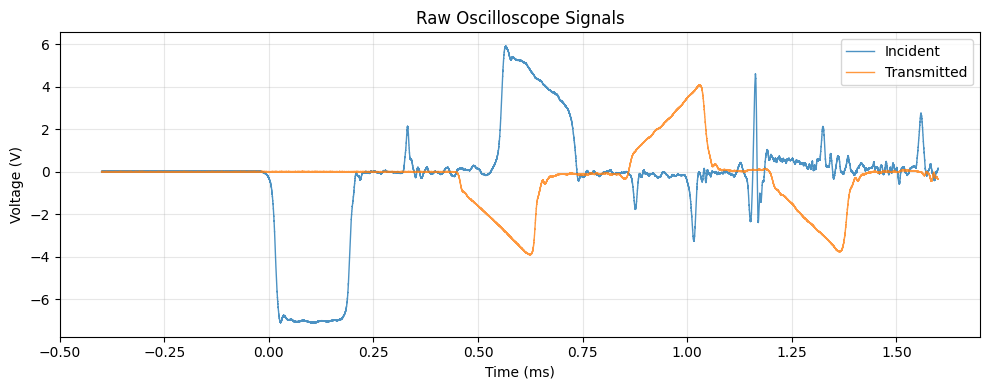

In [6]:
# Visualize raw signals
plt.figure(figsize=(10, 4))
plt.plot(raw_df["time"], raw_df["incident"], lw=1, label="Incident", alpha=0.8)
plt.plot(raw_df["time"], raw_df["transmitted"], lw=1, label="Transmitted", alpha=0.8)
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (V)")
plt.title("Raw Oscilloscope Signals")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

---
## 3. Equipment Configuration

Define test metadata and extract equipment properties (bar dimensions, wave speed, gauge factors) from the ontology.

In [7]:
# ============================================================
# USER INPUT: Test conditions and equipment selection
# ============================================================
# Test Overview - Date, User, Type (Specimen, Calibration)
TEST_DATE = "2025-11-12"
USER = "dyn:User_ErwinCazares"
TEST_TYPE = "dyn:SpecimenTest"  # Options: SpecimenTest, CalibrationTest

# Equipment URIs (from dynamat/ontology/class_individuals/mechanical_testing_individuals.ttl)
STRIKER_BAR = "dyn:StrikerBar_C350_18in_0375in"
INCIDENT_BAR = "dyn:IncidentBar_C350_8ft_0375in"
TRANSMISSION_BAR = "dyn:TransmissionBar_C350_6ft_0375in"
INCIDENT_GAUGE = "dyn:StrainGauge_SHPB_001"
TRANSMISSION_GAUGE = "dyn:StrainGauge_SHPB_002"
MOMENTUM_TRAP = "dyn:MomentumTrap_TailoredGap"  # Options: TailoredGap, Full
PULSE_SHAPER = "dyn:PulseShaper_Copper_0015in"  # Options: 0015in, 0020in, 0025in

# Test conditions (with units)
STRIKER_VELOCITY = {'value': 23.27, 'unit': 'unit:M-PER-SEC', 'reference_unit': 'unit:M-PER-SEC'} # UnitValue Widgets.
STRIKER_PRESSURE = {'value': 77, 'unit': 'unit:PSI', 'reference_unit': 'unit:PSI'}
BARREL_OFFSET = {'value': 19.05, 'unit': 'unit:MilliM', 'reference_unit': 'unit:MilliM'}
MOMENTUM_TRAP_DISTANCE = {'value': 2.8, 'unit': 'unit:MilliM', 'reference_unit': 'unit:MilliM'}
LUBRICATION = True

# Create test metadata object
test_id = f"{specimen_id}_SHPBTest"
test_metadata = SHPBTestMetadata(
    test_id=test_id,
    specimen_uri=SPECIMEN_URI,
    test_date=TEST_DATE,
    user=USER,
    test_type = TEST_TYPE
    striker_bar_uri=STRIKER_BAR,
    incident_bar_uri=INCIDENT_BAR,
    transmission_bar_uri=TRANSMISSION_BAR,
    incident_strain_gauge_uri=INCIDENT_GAUGE,
    transmission_strain_gauge_uri=TRANSMISSION_GAUGE,
    momentum_trap_uri=MOMENTUM_TRAP,
    pulse_shaper_uri=PULSE_SHAPER,
    striker_velocity=STRIKER_VELOCITY,
    striker_launch_pressure=STRIKER_PRESSURE,
    barrel_offset=BARREL_OFFSET,
    momentum_trap_distance=MOMENTUM_TRAP_DISTANCE,
    lubrication_applied=LUBRICATION
)

test_metadata.validate()
print(f"Test ID: {test_metadata.test_id}")
print(f"Specimen: {test_metadata.specimen_uri}")
print(f"Date: {test_metadata.test_date}")

Test ID: DYNML-SS316A356-0050_SHPBTest
Specimen: https://dynamat.utep.edu/ontology#DYNML_SS316A356_0050
Date: 2025-11-12


In [8]:
# Extract equipment properties from ontology
equipment = test_metadata.extract_all_equipment_properties(specimen_loader)

# Bar properties
bar_cross_section = equipment['incident_bar']['cross_section']      # mm^2
bar_wave_speed = equipment['incident_bar']['wave_speed']            # m/s
bar_elastic_modulus = equipment['incident_bar']['elastic_modulus']  # MPa
bar_density = equipment['incident_bar']['density']                  # kg/m^3
striker_length = equipment['striker_bar']['length']                 # mm
striker_velocity = test_metadata.striker_velocity['value']          # m/s

# Specimen properties
specimen_cross_section = specimen_data['dimensions']['hasOriginalCrossSection']  # mm^2
specimen_height = specimen_data['dimensions']['hasOriginalHeight']               # mm

# Strain gauge calibration parameters
incident_reflected_gauge_params = {
    'gauge_res': equipment['incident_gauge']['gauge_resistance'],
    'gauge_factor': equipment['incident_gauge']['gauge_factor'],
    'cal_voltage': equipment['incident_gauge']['calibration_voltage'],
    'cal_resistance': equipment['incident_gauge']['calibration_resistance']
}
transmitted_gauge_params = {
    'gauge_res': equipment['transmission_gauge']['gauge_resistance'],
    'gauge_factor': equipment['transmission_gauge']['gauge_factor'],
    'cal_voltage': equipment['transmission_gauge']['calibration_voltage'],
    'cal_resistance': equipment['transmission_gauge']['calibration_resistance']
}

print("Equipment properties extracted:")
print(f"  Bar area: {bar_cross_section:.2f} mm^2")
print(f"  Bar wave speed: {bar_wave_speed:.1f} m/s")
print(f"  Bar modulus: {bar_elastic_modulus/1000:.1f} GPa")
print(f"  Specimen area: {specimen_cross_section:.2f} mm^2")
print(f"  Specimen height: {specimen_height:.2f} mm")

Equipment properties extracted:
  Bar area: 71.26 mm^2
  Bar wave speed: 4953.3 m/s
  Bar modulus: 200.0 GPa
  Specimen area: 31.16 mm^2
  Specimen height: 6.40 mm


---
## 4. Pulse Detection Configuration

Calculate theoretical pulse duration from striker geometry and initialize pulse detector.

In [9]:
# Calculate theoretical pulse properties from striker geometry
pulse_duration_ms = (2 * striker_length) / bar_wave_speed    # duration = 2L/C
pulse_length = 2 * striker_length                            # spatial length
dt = np.median(np.diff(raw_df["time"])).astype("float")      # sampling interval (ms)
pulse_pts = int(pulse_duration_ms / dt)                      # pulse width in samples

# Theoretical pulse amplitudes
pulse_stress_amplitude = (0.5 * bar_density * bar_wave_speed * striker_velocity) / 1000  # MPa
pulse_strain_amplitude = 0.5 * (striker_velocity / bar_wave_speed)

print(f"Theoretical pulse properties:")
print(f"  Duration: {pulse_duration_ms:.4f} ms ({pulse_pts} samples)")
print(f"  Length: {pulse_length:.1f} mm")
print(f"  Stress amplitude: {pulse_stress_amplitude:.1f} MPa")
print(f"  Strain amplitude: {pulse_strain_amplitude:.3e}")

# Initialize pulse detector
detector = PulseDetector(
    pulse_points=pulse_pts,
    k_trials=(5000, 2000, 1000),  # SNR thresholds to try
    polarity="compressive",
    min_separation=int(0.8 * pulse_pts)
)

Theoretical pulse properties:
  Duration: 0.1846 ms (14768 samples)
  Length: 914.4 mm
  Stress amplitude: 465.8 MPa
  Strain amplitude: 2.349e-03


In [10]:
# Store pulse properties in metadata for RDF export
test_metadata.pulse_duration = {'value': pulse_duration_ms, 'unit': 'unit:MilliSEC', 'reference_unit': 'unit:MilliSEC'}
test_metadata.pulse_length = {'value': pulse_length, 'unit': 'unit:MilliM', 'reference_unit': 'unit:MilliM'}
test_metadata.pulse_stress_amplitude = {'value': pulse_stress_amplitude, 'unit': 'unit:MegaPA', 'reference_unit': 'unit:MegaPA'}
test_metadata.pulse_strain_amplitude = pulse_strain_amplitude
test_metadata.sampling_interval = {'value': dt * 1000, 'unit': 'unit:MicroSEC', 'reference_unit': 'unit:MicroSEC'}

---
## 5. Pulse Window Detection

Automatically detect pulse locations in the raw signals. Search bounds limit the region to avoid noise artifacts.

In [11]:
# ============================================================
# USER INPUT: Search bounds for incident pulse detection
# ============================================================
INC_LOWER_BOUND = 10000   # Start searching after this sample index
INC_UPPER_BOUND = 50000   # Stop searching before this sample index

# Detect incident pulse (compressive, in incident channel)
incident_window = detector.find_window(
    raw_df["incident"].values,
    lower_bound=INC_LOWER_BOUND,
    upper_bound=INC_UPPER_BOUND,
    metric="median",
    debug=False
)
print(f"Incident window: samples {incident_window[0]} to {incident_window[1]}")

# Store detection parameters
test_metadata.incident_pulse_points = int(detector.pulse_points)
test_metadata.incident_k_trials = ','.join(map(str, detector.k_trials))
test_metadata.incident_polarity = detector.polarity
test_metadata.incident_min_separation = detector.min_separation
test_metadata.incident_lower_bound = int(INC_LOWER_BOUND)
test_metadata.incident_upper_bound = int(INC_UPPER_BOUND)
test_metadata.incident_detection_metric = "median"
test_metadata.incident_window_start = int(incident_window[0])
test_metadata.incident_window_end = int(incident_window[1])
test_metadata.incident_window_length = int(incident_window[1] - incident_window[0])

Incident window: samples 32128 to 46896


In [12]:
# ============================================================
# USER INPUT: Search bounds for transmitted pulse detection
# ============================================================
TRS_LOWER_BOUND = 10000
TRS_UPPER_BOUND = 115000

# Detect transmitted pulse (compressive, in transmission channel)
transmitted_detector = PulseDetector(
    pulse_points=pulse_pts,
    k_trials=(1500, 1000, 800),  # Lower thresholds for weaker signal
    polarity="compressive"
)
transmitted_window = transmitted_detector.find_window(
    raw_df["transmitted"].values,
    lower_bound=TRS_LOWER_BOUND,
    upper_bound=TRS_UPPER_BOUND,
    metric="median",
    debug=False
)
print(f"Transmitted window: samples {transmitted_window[0]} to {transmitted_window[1]}")

# Store detection parameters
test_metadata.transmitted_pulse_points = int(transmitted_detector.pulse_points)
test_metadata.transmitted_k_trials = ','.join(map(str, transmitted_detector.k_trials))
test_metadata.transmitted_polarity = transmitted_detector.polarity
test_metadata.transmitted_min_separation = transmitted_detector.min_separation
test_metadata.transmitted_lower_bound = int(TRS_LOWER_BOUND)
test_metadata.transmitted_upper_bound = int(TRS_UPPER_BOUND)
test_metadata.transmitted_detection_metric = "median"
test_metadata.transmitted_window_start = int(transmitted_window[0])
test_metadata.transmitted_window_end = int(transmitted_window[1])
test_metadata.transmitted_window_length = int(transmitted_window[1] - transmitted_window[0])

Transmitted window: samples 70106 to 84874


In [13]:
# ============================================================
# USER INPUT: Search bounds for reflected pulse detection
# ============================================================
REF_LOWER_BOUND = 10000
REF_UPPER_BOUND = 115000

# Detect reflected pulse (tensile, in incident channel)
reflected_detector = PulseDetector(
    pulse_points=pulse_pts,
    k_trials=(1500, 1000, 500),
    polarity="tensile",  # Reflected wave is tensile
    min_separation=int(0.6 * pulse_pts)
)
reflected_window = reflected_detector.find_window(
    raw_df["incident"].values,  # Reflected is in incident channel
    lower_bound=REF_LOWER_BOUND,
    upper_bound=REF_UPPER_BOUND,
    metric="median",
    debug=False
)
print(f"Reflected window: samples {reflected_window[0]} to {reflected_window[1]}")

# Store detection parameters
test_metadata.reflected_pulse_points = int(reflected_detector.pulse_points)
test_metadata.reflected_k_trials = ','.join(map(str, reflected_detector.k_trials))
test_metadata.reflected_polarity = reflected_detector.polarity
test_metadata.reflected_min_separation = reflected_detector.min_separation
test_metadata.reflected_lower_bound = int(REF_LOWER_BOUND)
test_metadata.reflected_upper_bound = int(REF_UPPER_BOUND)
test_metadata.reflected_detection_metric = "median"
test_metadata.reflected_window_start = int(reflected_window[0])
test_metadata.reflected_window_end = int(reflected_window[1])
test_metadata.reflected_window_length = int(reflected_window[1] - reflected_window[0])

Reflected window: samples 71093 to 85861


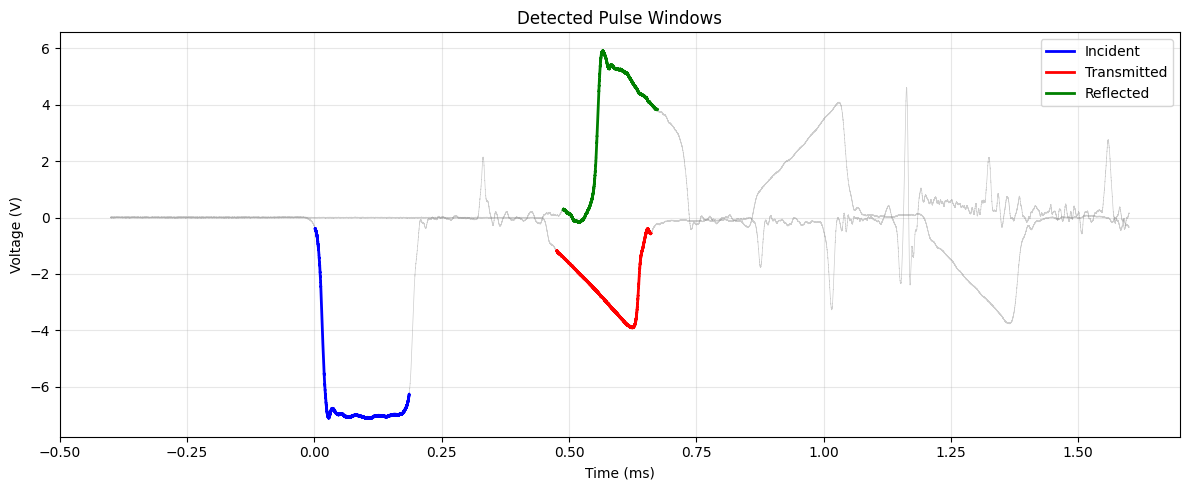

Window lengths: Incident=14768, Transmitted=14768, Reflected=14768 samples


In [14]:
# Visualize detected pulse windows
i0, i1 = incident_window
t0, t1 = transmitted_window
r0, r1 = reflected_window

fig, ax = plt.subplots(figsize=(12, 5))

# Full raw traces (faded)
ax.plot(raw_df["time"], raw_df["incident"], lw=0.5, alpha=0.4, label="_nolegend_", c="gray")
ax.plot(raw_df["time"], raw_df["transmitted"], lw=0.5, alpha=0.4, label="_nolegend_", c="gray")

# Highlight detected windows
ax.plot(raw_df["time"].iloc[i0:i1], raw_df["incident"].iloc[i0:i1], lw=2, label="Incident", c="blue")
ax.plot(raw_df["time"].iloc[t0:t1], raw_df["transmitted"].iloc[t0:t1], lw=2, label="Transmitted", c="red")
ax.plot(raw_df["time"].iloc[r0:r1], raw_df["incident"].iloc[r0:r1], lw=2, label="Reflected", c="green")

ax.set_xlabel("Time (ms)")
ax.set_ylabel("Voltage (V)")
ax.set_title("Detected Pulse Windows")
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Window lengths: Incident={i1-i0}, Transmitted={t1-t0}, Reflected={r1-r0} samples")

---
## 6. Pulse Segmentation

Extract fixed-length segments centered on the pulse peaks. All pulses are normalized to the same length for alignment.

In [15]:
# ============================================================
# USER INPUT: Segment length and threshold
# ============================================================
N_POINTS = 25000    # Fixed segment length for all pulses
THRESH_RATIO = 0    # Noise threshold (0 = keep all data)

# Segment and center each pulse
inc_seg = detector.segment_and_center(
    raw_df["incident"].values, incident_window,
    n_points=N_POINTS, polarity="compressive", thresh_ratio=THRESH_RATIO, debug=False
)
trs_seg = transmitted_detector.segment_and_center(
    raw_df["transmitted"].values, transmitted_window,
    n_points=N_POINTS, polarity="compressive", thresh_ratio=THRESH_RATIO, debug=False
)
ref_seg = reflected_detector.segment_and_center(
    raw_df["incident"].values, reflected_window,
    n_points=N_POINTS, polarity="tensile", thresh_ratio=THRESH_RATIO, debug=False
)

# Store segmentation parameters
test_metadata.segment_n_points = int(N_POINTS)
test_metadata.segment_thresh_ratio = float(THRESH_RATIO)

print(f"Segmented pulses: {inc_seg.shape[0]} points each")

Segmented pulses: 25000 points each


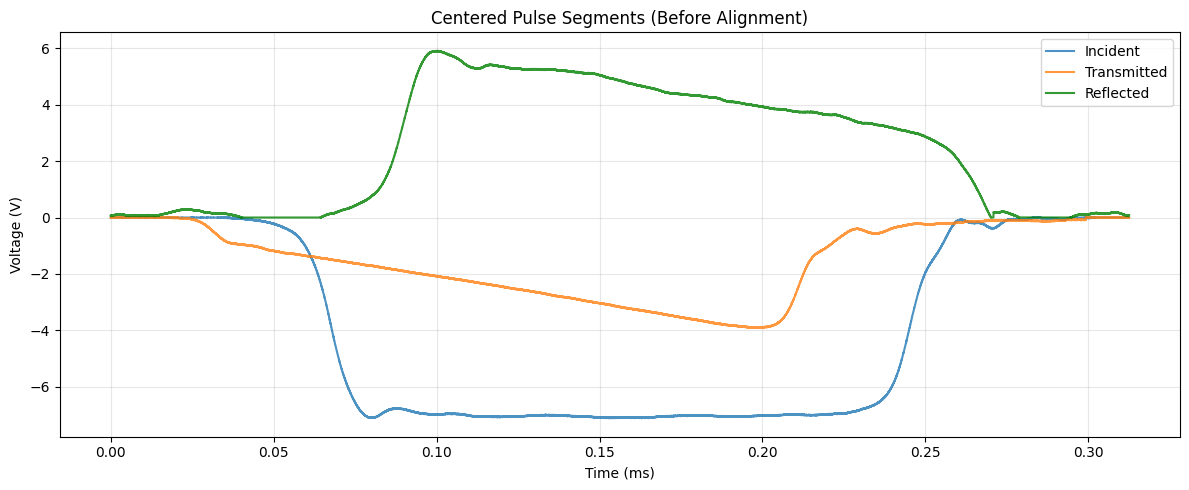

In [16]:
# Visualize centered pulses
time_seg = np.arange(N_POINTS) * dt

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(time_seg, inc_seg, lw=1.5, label="Incident", alpha=0.8)
ax.plot(time_seg, trs_seg, lw=1.5, label="Transmitted", alpha=0.8)
ax.plot(time_seg, ref_seg, lw=1.5, label="Reflected", alpha=0.8, c="green")
ax.set_xlabel("Time (ms)")
ax.set_ylabel("Voltage (V)")
ax.set_title("Centered Pulse Segments (Before Alignment)")
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

---
## 7. Pulse Alignment

Optimize temporal alignment of transmitted and reflected pulses relative to incident pulse to achieve force equilibrium at specimen interfaces.

In [17]:
# ============================================================
# USER INPUT: Alignment optimization parameters
# ============================================================
# Fitness function weights (sum should equal 1.0)
OPT_WEIGHTS = {'corr': 0.3, 'u': 0.3, 'sr': 0.3, 'e': 0.1}

# Linear region fraction (fraction of loading slope to define linear region)
K_LINEAR = 0.35

# Search bounds for shift optimization (samples)
SEARCH_BOUNDS_T = (3200, 3300)   # Transmitted pulse shift range
SEARCH_BOUNDS_R = (-2200, -1800) # Reflected pulse shift range

# Initialize aligner
aligner = PulseAligner(
    bar_wave_speed=bar_wave_speed,
    specimen_height=specimen_height,
    k_linear=K_LINEAR,
    weights=OPT_WEIGHTS
)

# Run alignment optimization
inc_aligned, trs_aligned, ref_aligned, shift_t, shift_r = aligner.align(
    incident=inc_seg,
    transmitted=trs_seg,
    reflected=ref_seg,
    time_vector=time_seg,
    search_bounds_t=SEARCH_BOUNDS_T,
    search_bounds_r=SEARCH_BOUNDS_R,
    debug=False
)

print(f"Alignment complete:")
print(f"  Transmitted shift: {shift_t:+d} samples")
print(f"  Reflected shift: {shift_r:+d} samples")

# Store alignment parameters in metadata
test_metadata.k_linear = K_LINEAR
test_metadata.alignment_weight_corr = OPT_WEIGHTS['corr']
test_metadata.alignment_weight_u = OPT_WEIGHTS['u']
test_metadata.alignment_weight_sr = OPT_WEIGHTS['sr']
test_metadata.alignment_weight_e = OPT_WEIGHTS['e']
test_metadata.search_bounds_t_min = int(SEARCH_BOUNDS_T[0])
test_metadata.search_bounds_t_max = int(SEARCH_BOUNDS_T[1])
test_metadata.search_bounds_r_min = int(SEARCH_BOUNDS_R[0])
test_metadata.search_bounds_r_max = int(SEARCH_BOUNDS_R[1])
test_metadata.shift_transmitted = int(shift_t)
test_metadata.shift_reflected = int(shift_r)

Alignment complete:
  Transmitted shift: +3271 samples
  Reflected shift: -1846 samples


In [18]:
# Center time axis on incident pulse rise (t=0 at 8% of max amplitude)
FRONT_THRESH = 0.08
inc_abs = np.abs(inc_aligned)
front_idx = np.argmax(inc_abs > FRONT_THRESH * inc_abs.max())
time_aligned = (np.arange(N_POINTS) - front_idx) * dt

# Store in metadata
test_metadata.front_thresh = float(FRONT_THRESH)
test_metadata.alignment_front_idx = int(front_idx)

print(f"Time axis centered at sample {front_idx} (t=0 at pulse rise)")

Time axis centered at sample 4516 (t=0 at pulse rise)


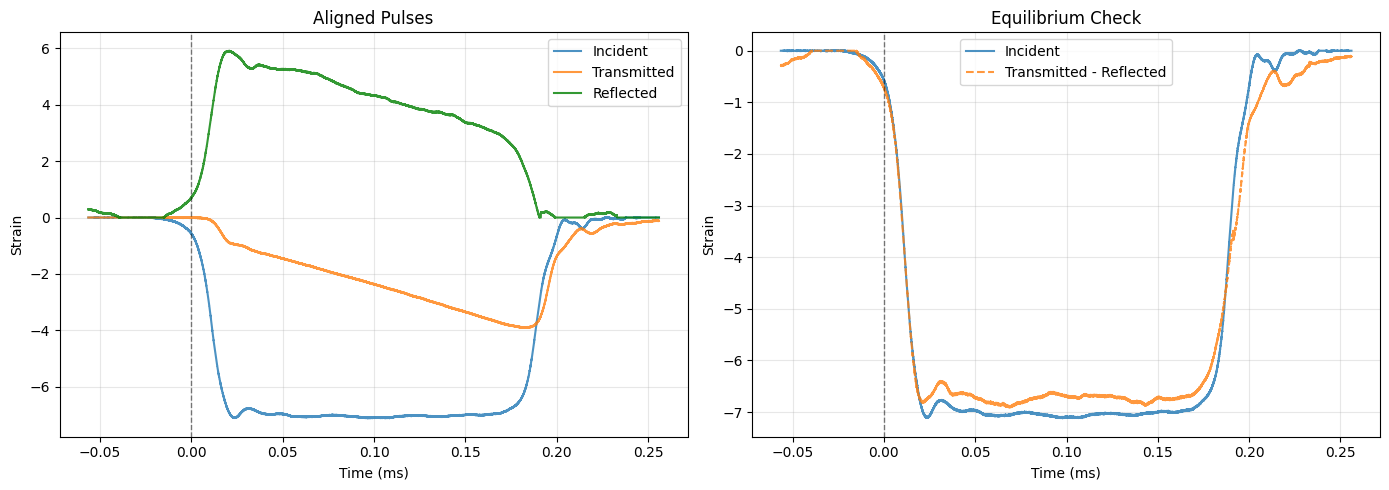

In [19]:
# Visualize aligned pulses and equilibrium check
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Aligned pulses
ax1.plot(time_aligned, inc_aligned, lw=1.5, label="Incident", alpha=0.8)
ax1.plot(time_aligned, trs_aligned, lw=1.5, label="Transmitted", alpha=0.8)
ax1.plot(time_aligned, ref_aligned, lw=1.5, label="Reflected", c="green", alpha=0.8)
ax1.axvline(0, ls="--", c="k", lw=1, alpha=0.5)
ax1.set_xlabel("Time (ms)")
ax1.set_ylabel("Strain")
ax1.set_title("Aligned Pulses")
ax1.legend()
ax1.grid(alpha=0.3)

# Equilibrium check: Incident vs (Transmitted - Reflected)
equilibrium_check = trs_aligned - ref_aligned
ax2.plot(time_aligned, inc_aligned, lw=1.5, label="Incident", alpha=0.8)
ax2.plot(time_aligned, equilibrium_check, lw=1.5, ls='--', label="Transmitted - Reflected", alpha=0.8)
ax2.axvline(0, ls="--", c="k", lw=1, alpha=0.5)
ax2.set_xlabel("Time (ms)")
ax2.set_ylabel("Strain")
ax2.set_title("Equilibrium Check")
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

---
## 8. Stress-Strain Calculation

Calculate engineering and true stress-strain curves using 1-wave and 3-wave analysis methods.

In [20]:
# Initialize stress-strain calculator with voltage-to-strain conversion
calculator = StressStrainCalculator(
    bar_area=bar_cross_section,
    bar_wave_speed=bar_wave_speed,
    bar_elastic_modulus=bar_elastic_modulus,
    specimen_area=specimen_cross_section,
    specimen_height=specimen_height,
    strain_scale_factor=1,
    use_voltage_input=True,
    incident_reflected_gauge_params=incident_reflected_gauge_params,
    transmitted_gauge_params=transmitted_gauge_params
)

print(f"Calculator initialized (area ratio: {calculator.area_ratio:.3f})")

Calculator initialized (area ratio: 2.286)


In [34]:
# Calculate stress-strain curves (1-wave and 3-wave methods)
all_results = calculator.calculate(
    incident=inc_aligned,
    transmitted=trs_aligned,
    reflected=ref_aligned,
    time_vector=time_aligned
)

# Calculate incident rise time
inc_rise_time = detector.calculate_rise_time(inc_aligned, time_aligned)
test_metadata.incident_rise_time = {'value': inc_rise_time, 'unit': 'unit:MilliSEC', 'reference_unit': 'unit:MilliSEC'}

print(f"Results calculated:")
print(f"  Peak stress (1w): {stress_1w.max():.1f} MPa")
print(f"  Peak strain (1w): {strain_1w.max():.4f}")
print(f"  Max strain rate: {strain_rate_1w.max():.0f} 1/s")
print(f"  Rise time: {inc_rise_time:.4f} ms")

Results calculated:
  Peak stress (1w): 868.2 MPa
  Peak strain (1w): 0.5844
  Max strain rate: 4440 1/s
  Rise time: 0.0152 ms


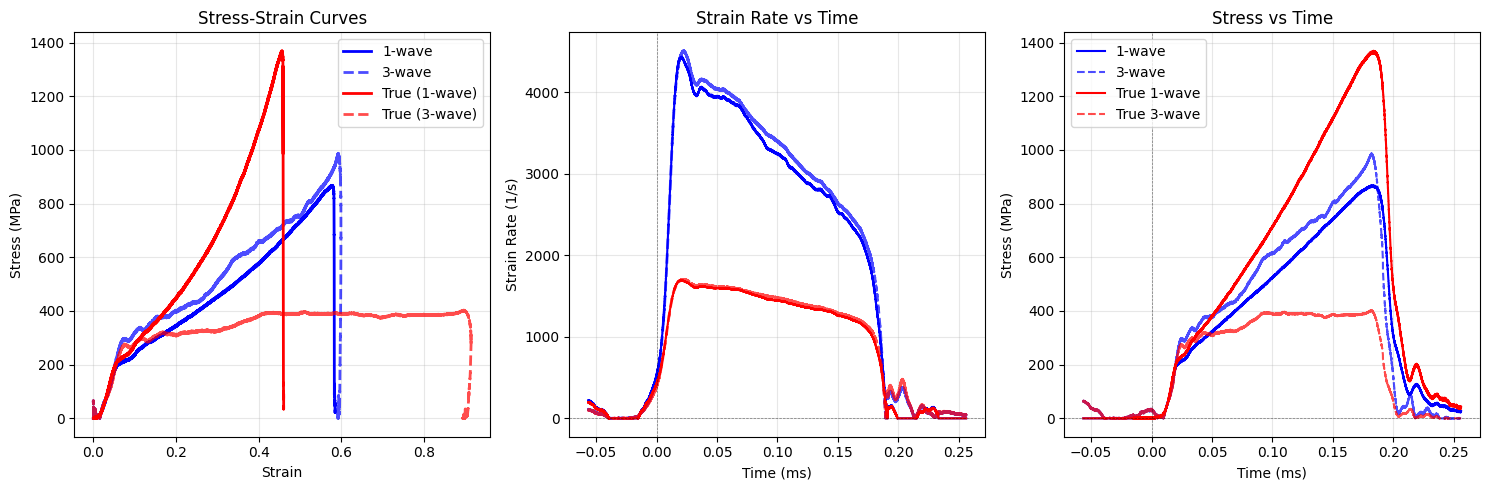

In [35]:
# Visualize stress-strain results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Stress-Strain curves
axes[0].plot(all_results['strain_1w'], all_results['stress_1w'], lw=2, label='1-wave', c='blue')
axes[0].plot(all_results['strain_3w'], all_results['stress_3w'], lw=2, ls='--', label='3-wave', c='blue', alpha=0.7)
axes[0].plot(all_results['true_strain_1w'], all_results['true_stress_1w'], lw=2, label='True (1-wave)', c='red')
axes[0].plot(all_results['true_strain_3w'], all_results['true_stress_3w'], lw=2, ls='--', label='True (3-wave)', c='red', alpha=0.7)
axes[0].set_xlabel('Strain')
axes[0].set_ylabel('Stress (MPa)')
axes[0].set_title('Stress-Strain Curves')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Strain rate vs time
axes[1].plot(all_results['time'], all_results['strain_rate_1w'], lw=1.5, label='1-wave', c='blue')
axes[1].plot(all_results['time'], all_results['strain_rate_3w'], lw=2, ls='--', label='3-wave', c='blue', alpha=0.7)
axes[1].plot(all_results['time'], all_results['true_strain_rate_1w'], lw=1.5, label='True 1-wave', c='red')
axes[1].plot(all_results['time'], all_results['true_strain_rate_3w'], lw=2, ls='--', label='True 3-wave', c='red', alpha=0.7)
axes[1].axhline(0, ls='--', c='k', lw=0.5, alpha=0.5)
axes[1].axvline(0, ls='--', c='k', lw=0.5, alpha=0.5)
axes[1].set_xlabel('Time (ms)')
axes[1].set_ylabel('Strain Rate (1/s)')
axes[1].set_title('Strain Rate vs Time')
axes[1].grid(alpha=0.3)

# Stress vs time
axes[2].plot(all_results['time'], all_results['stress_1w'], lw=1.5, label='1-wave', c='blue')
axes[2].plot(all_results['time'], all_results['stress_3w'], lw=1.5, ls='--', label='3-wave', c='blue', alpha=0.7)
axes[2].plot(all_results['time'], all_results['true_stress_1w'], lw=1.5, label='True 1-wave', c='red')
axes[2].plot(all_results['time'], all_results['true_stress_3w'], lw=1.5, ls='--', label='True 3-wave', c='red', alpha=0.7)
axes[2].axhline(0, ls='--', c='k', lw=0.5, alpha=0.5)
axes[2].axvline(0, ls='--', c='k', lw=0.5, alpha=0.5)
axes[2].set_xlabel('Time (ms)')
axes[2].set_ylabel('Stress (MPa)')
axes[2].set_title('Stress vs Time')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

---
## 9. Equilibrium Assessment

Calculate validity metrics to assess test quality:
- **FBC** (Force Balance Coefficient): Ratio of transmitted to incident+reflected forces
- **DSUF** (Dynamic Stress Uniformity Factor): R^2 of front/back stress correlation
- **SEQI** (Stress Equilibrium Quality Index): Combined equilibrium measure
- **SOI** (Stress Oscillation Index): Normalized oscillation amplitude

In [26]:
# Calculate equilibrium metrics
metrics = calculator.calculate_equilibrium_metrics(all_results)

print("EQUILIBRIUM METRICS")
print("=" * 50)
print(f"FBC:  {metrics['FBC']:.4f}  (target: >0.95)")
print(f"DSUF: {metrics['DSUF']:.4f}  (target: >0.98)")
print(f"SEQI: {metrics['SEQI']:.4f}  (target: >0.90)")
print(f"SOI:  {metrics['SOI']:.4f}  (target: <0.05)")
print("=" * 50)

print("\nPhase-specific metrics:")
print(f"  Loading:   FBC={metrics['windowed_FBC_loading']:.3f}, DSUF={metrics['windowed_DSUF_loading']:.3f}")
print(f"  Plateau:   FBC={metrics['windowed_FBC_plateau']:.3f}, DSUF={metrics['windowed_DSUF_plateau']:.3f}")
print(f"  Unloading: FBC={metrics['windowed_FBC_unloading']:.3f}, DSUF={metrics['windowed_DSUF_unloading']:.3f}")

# Store metrics in metadata
test_metadata.fbc = metrics['FBC']
test_metadata.seqi = metrics['SEQI']
test_metadata.soi = metrics['SOI']
test_metadata.dsuf = metrics['DSUF']
test_metadata.fbc_loading = metrics['windowed_FBC_loading']
test_metadata.dsuf_loading = metrics['windowed_DSUF_loading']
test_metadata.fbc_plateau = metrics['windowed_FBC_plateau']
test_metadata.dsuf_plateau = metrics['windowed_DSUF_plateau']
test_metadata.fbc_unloading = metrics['windowed_FBC_unloading']
test_metadata.dsuf_unloading = metrics['windowed_DSUF_unloading']

EQUILIBRIUM METRICS
FBC:  0.7889  (target: >0.95)
DSUF: 0.9277  (target: >0.98)
SEQI: 0.9155  (target: >0.90)
SOI:  0.0639  (target: <0.05)

Phase-specific metrics:
  Loading:   FBC=0.678, DSUF=0.686
  Plateau:   FBC=0.896, DSUF=0.892
  Unloading: FBC=0.495, DSUF=0.911


---
## 10. Tukey Window (ML Preprocessing)

Apply Tukey window tapering to reduce edge discontinuities for neural network input. The alpha parameter controls the taper fraction (0=rectangular, 1=Hann window).

In [28]:
# ============================================================
# USER INPUT: Tukey window parameter
# ============================================================
TUKEY_ALPHA = 0.58  # Taper fraction (0.5 = 50% taper recommended)

# Apply Tukey window to aligned pulses
tukey = TukeyWindow(alpha=TUKEY_ALPHA)
inc_tapered = tukey.apply(inc_aligned)
trs_tapered = tukey.apply(trs_aligned)
ref_tapered = tukey.apply(ref_aligned)

# Store parameter
test_metadata.tukey_alpha = TUKEY_ALPHA

# Energy analysis
energy_before = np.sum(inc_aligned**2)
energy_after = np.sum(inc_tapered**2)
energy_loss = float(100 * (1 - energy_after / energy_before))

print(f"Tukey window applied (alpha={TUKEY_ALPHA})")
print(f"Energy loss: {energy_loss:.1f}%")

Tukey window applied (alpha=0.58)
Energy loss: 2.2%


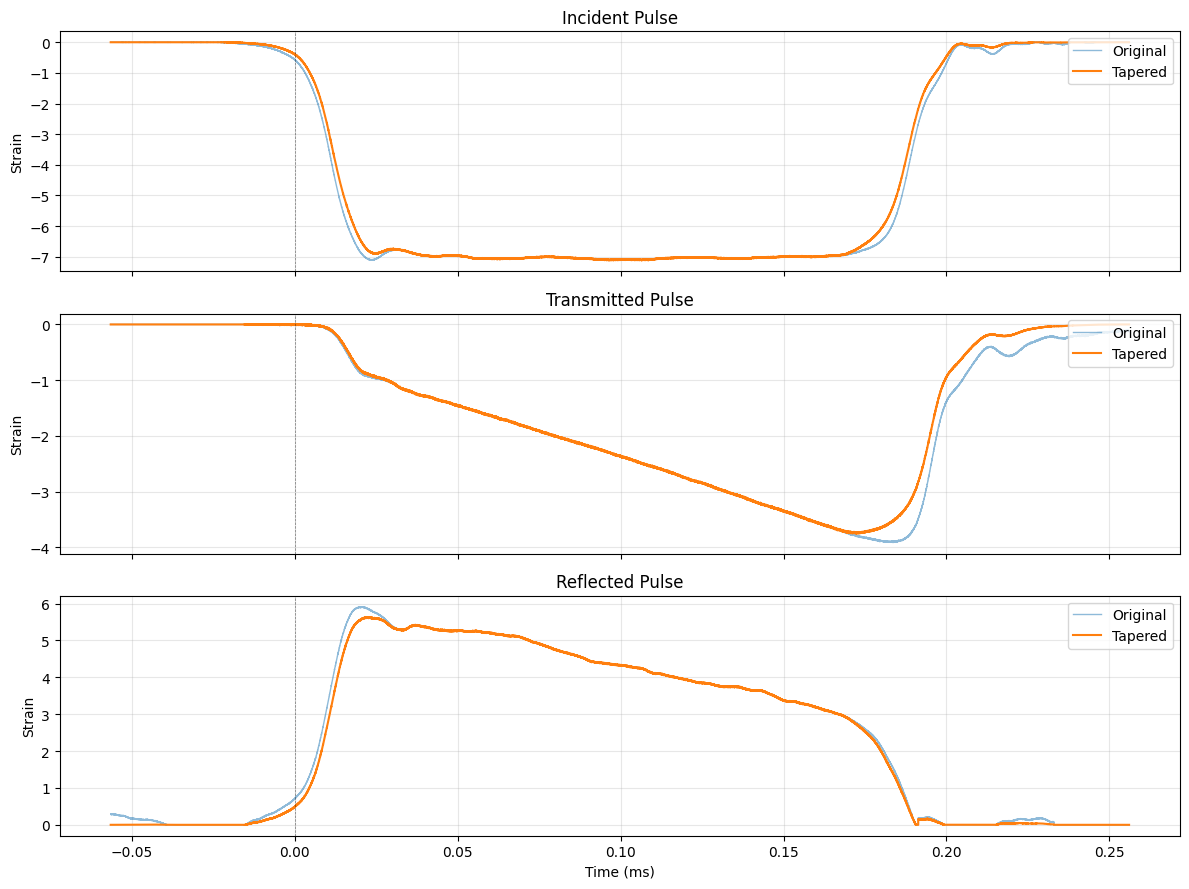

In [29]:
# Visualize Tukey window effect
fig, axes = plt.subplots(3, 1, figsize=(12, 9), sharex=True)

for ax, (name, orig, tapered) in zip(axes, [
    ('Incident', inc_aligned, inc_tapered),
    ('Transmitted', trs_aligned, trs_tapered),
    ('Reflected', ref_aligned, ref_tapered)
]):
    ax.plot(time_aligned, orig, lw=1, alpha=0.5, label='Original')
    ax.plot(time_aligned, tapered, lw=1.5, label='Tapered')
    ax.axvline(0, ls='--', c='k', lw=0.5, alpha=0.5)
    ax.set_ylabel('Strain')
    ax.set_title(f'{name} Pulse')
    ax.legend(loc='upper right')
    ax.grid(alpha=0.3)

axes[-1].set_xlabel('Time (ms)')
plt.tight_layout()
plt.show()

---
## 11. Validity Assessment

Determine overall test validity based on equilibrium metrics:
- **VALID**: All strict criteria passed (FBC>=0.95, SEQI>=0.90, SOI<=0.05, DSUF>=0.98)
- **QUESTIONABLE**: At least 2 relaxed criteria passed
- **INVALID**: Less than 2 relaxed criteria passed

In [30]:
# Assess validity from equilibrium metrics
test_metadata.assess_validity_from_metrics(metrics)

fbc = metrics['FBC']
seqi = metrics['SEQI']
soi = metrics['SOI']
dsuf = metrics['DSUF']

# Count passing criteria
strict_pass = sum([fbc >= 0.95, seqi >= 0.90, soi <= 0.05, dsuf >= 0.98])
relaxed_pass = sum([fbc >= 0.85, seqi >= 0.80, soi <= 0.10, dsuf >= 0.90])

print("VALIDITY ASSESSMENT")
print("=" * 50)
print(f"Status: {test_metadata.test_validity}")
print(f"Criteria met: {test_metadata.validity_criteria}")
print("=" * 50)

print("\nStrict criteria:")
print(f"  FBC >= 0.95:   {'PASS' if fbc >= 0.95 else 'FAIL'} ({fbc:.4f})")
print(f"  SEQI >= 0.90:  {'PASS' if seqi >= 0.90 else 'FAIL'} ({seqi:.4f})")
print(f"  SOI <= 0.05:   {'PASS' if soi <= 0.05 else 'FAIL'} ({soi:.4f})")
print(f"  DSUF >= 0.98:  {'PASS' if dsuf >= 0.98 else 'FAIL'} ({dsuf:.4f})")
print(f"  Result: {strict_pass}/4 passed")

print("\nRelaxed criteria:")
print(f"  FBC >= 0.85:   {'PASS' if fbc >= 0.85 else 'FAIL'}")
print(f"  SEQI >= 0.80:  {'PASS' if seqi >= 0.80 else 'FAIL'}")
print(f"  SOI <= 0.10:   {'PASS' if soi <= 0.10 else 'FAIL'}")
print(f"  DSUF >= 0.90:  {'PASS' if dsuf >= 0.90 else 'FAIL'}")
print(f"  Result: {relaxed_pass}/4 passed")

print("\n" + "=" * 50)
if test_metadata.is_valid():
    print("VERDICT: VALID")
elif test_metadata.is_questionable():
    print("VERDICT: QUESTIONABLE - Review data carefully")
else:
    print("VERDICT: INVALID")
print("=" * 50)

VALIDITY ASSESSMENT
Status: dyn:QuestionableTest
Criteria met: ['dyn:ConstantStrainRate']

Strict criteria:
  FBC >= 0.95:   FAIL (0.7889)
  SEQI >= 0.90:  PASS (0.9155)
  SOI <= 0.05:   FAIL (0.0639)
  DSUF >= 0.98:  FAIL (0.9277)
  Result: 1/4 passed

Relaxed criteria:
  FBC >= 0.85:   FAIL
  SEQI >= 0.80:  PASS
  SOI <= 0.10:   PASS
  DSUF >= 0.90:  PASS
  Result: 3/4 passed

VERDICT: QUESTIONABLE - Review data carefully


---
## 12. RDF Export

Save all test metadata and results to ontology (TTL file) with full provenance tracking.

In [ ]:
# Set analysis timestamp and data series URIs
test_metadata.analysis_timestamp = datetime.now().isoformat()

# Generate URIs for data series and processing objects
test_uri_base = test_id.replace("-", "_")
test_metadata.data_series_time_uri = f'dyn:{test_uri_base}_time'
test_metadata.data_series_incident_uri = f'dyn:{test_uri_base}_incident'
test_metadata.data_series_transmitted_uri = f'dyn:{test_uri_base}_transmitted'

test_metadata.incident_window_uri = f'dyn:{test_uri_base}_inc_window'
test_metadata.transmitted_window_uri = f'dyn:{test_uri_base}_trs_window'
test_metadata.reflected_window_uri = f'dyn:{test_uri_base}_ref_window'
test_metadata.transmitted_shift_uri = f'dyn:{test_uri_base}_trs_shift'
test_metadata.reflected_shift_uri = f'dyn:{test_uri_base}_ref_shift'
test_metadata.incident_detection_params_uri = f'dyn:{test_uri_base}_inc_detect'
test_metadata.transmitted_detection_params_uri = f'dyn:{test_uri_base}_trs_detect'
test_metadata.reflected_detection_params_uri = f'dyn:{test_uri_base}_ref_detect'
test_metadata.alignment_params_uri = f'dyn:{test_uri_base}_alignment'
test_metadata.equilibrium_metrics_uri = f'dyn:{test_uri_base}_equilibrium'

# Write to RDF
writer = SHPBTestWriter(ontology_manager, qudt_manager)
test_path, validation = writer.ingest_test(
    test_metadata,
    raw_df,
    processed_results=all_results
)

if test_path:
    print(f"Test saved: {test_path}")
    print(f"  Raw DataSeries: 3 instances")
    print(f"  Processed DataSeries: {len(all_results)} instances")
    if validation.has_any_issues():
        print(f"  Warnings: {validation.get_summary()}")
else:
    print(f"Export failed: {validation.get_summary()}")

In [ ]:
# Display validation issues if any
if validation.has_blocking_issues():
    print("VALIDATION ISSUES")
    print("=" * 50)
    for i, issue in enumerate(validation.violations, 1):
        print(f"{i}. {issue.get_display_message()}")
        if issue.focus_node:
            print(f"   Node: {issue.focus_node}")
    print("=" * 50)